## HLA-zoo

To know:
- the alignment of each set of reads againts the graphs is done with `rules/alignment_simreads.smk`
- due to the large amount of graphs for the same set of sequences, paths to gfa are indexed and stored in a json file, their identifiers are used to label the `*.gaf` file with the alignment results 
- in each folder you will find a file `gfaid_to_path`, the information to track the source gfa is in that file

In [1]:
import sys
import json
from pathlib import Path
from tqdm import tqdm

# add parent folder to the path
module_path = str(Path.cwd().parents[0])
if module_path not in sys.path:
    sys.path.append(module_path)

import pandas as pd; tqdm.pandas()
import seaborn as sns
import matplotlib.pyplot as plt
from utils.load_gaf import load_gaf, ABBV

In [2]:
tool="makeprg"
PATH_TOOL=Path("/data/pangeblocks-experiments/alignment-simulated-reads-HLA-zoo").joinpath(tool)

with open(Path(PATH_TOOL).joinpath("gfaid_to_paths.json")) as fp:
    gfaid_to_paths=json.load(fp)

In [3]:
path_gaf = list(Path(PATH_TOOL).rglob("*.gaf"))[0]
seqsid, gfaid, _ = path_gaf.stem.split(".")
gfaid = gfaid.replace("gfaid","")
path_gfa = "../"+ gfaid_to_paths[gfaid]

In [4]:
gaf = load_gaf(path_gaf=path_gaf, path_gfa=path_gfa)
gaf["seqsid"] = seqsid 
gaf["tool"] = tool
gaf["gfa"] = path_gfa

In [5]:
*_, mafft, _ = path_gfa.split("/")
mafft

'output-HLA-zoo-mafft.op3-ep0'

## Generic load

In [6]:
BASEPATH_ALIGN=Path("/data/pangeblocks-experiments/alignment-simulated-reads-HLA-zoo")

In [7]:
data_gafs = []

for TOOL in ["pangeblocks","pggb","PanPA","vg","makeprg"]:

    # load id to gfas
    with(open(BASEPATH_ALIGN.joinpath(TOOL) / "gfaid_to_paths.json" )) as fp: 
        gfaid_to_paths=json.load(fp)

    for path_gaf in tqdm(list(BASEPATH_ALIGN.joinpath(TOOL).rglob("*.gaf")), desc=TOOL):

        # load info related to the gfa
        seqsid, gfaid, _ = path_gaf.stem.split(".")
        gfaid = gfaid.replace("gfaid","")
        path_gfa =  "../" + gfaid_to_paths[gfaid]

        # 
        data_gaf = load_gaf(path_gaf=path_gaf, path_gfa=path_gfa)
        data_gaf["seqsid"] = seqsid 
        data_gaf["tool"] = TOOL
        data_gaf["gfa"] = path_gfa

        data_gafs.append(data_gaf)

makeprg: 100%|██████████| 78/78 [00:00<00:00, 100.73it/s]


In [8]:
data_gafs=pd.concat(data_gafs, ignore_index=True)

In [9]:
def get_id_plot(path_gfa):

    if "pangeblocks" in path_gfa:
        # loss function info
        *_,mafft,_,loss_func, pen_len,_ = path_gfa.split("/")
        
        op_ep = mafft.split("-mafft.")[-1]
        p, ml = pen_len.split("-")
        
        p=p.replace("penalization","p")
        ml=ml.replace("min_len","l")
        loss_func=loss_func[0]
        return "-".join(["pangeblocks","mafft",op_ep,loss_func,p,ml])
    
    if "pggb" in path_gfa:
        return "pggb"

    if "PanPA" in path_gfa:
        *_, mafft, _ = path_gfa.split("/")
        op_ep = mafft.split("-mafft.")[-1]
        return "-".join(["panpa","mafft",op_ep])

    if "vg" in path_gfa:
        *_, mafft, _ = path_gfa.split("/")
        op_ep = mafft.split("-mafft.")[-1]
        return "-".join(["vg","mafft",op_ep])

    if "makeprg" in path_gfa:
        *_, mafft, _ = path_gfa.split("/")
        op_ep = mafft.split("-mafft.")[-1]
        return "-".join(["makeprg","mafft",op_ep])

In [10]:
data_gafs["id_plot"] = data_gafs["gfa"].progress_apply(get_id_plot)

100%|██████████| 469328/469328 [00:00<00:00, 481632.16it/s]


In [11]:
iter_seqsid=iter(data_gafs["seqsid"].unique())

Text(0.5, 1.0, 'Boxplot | gene A-3105')

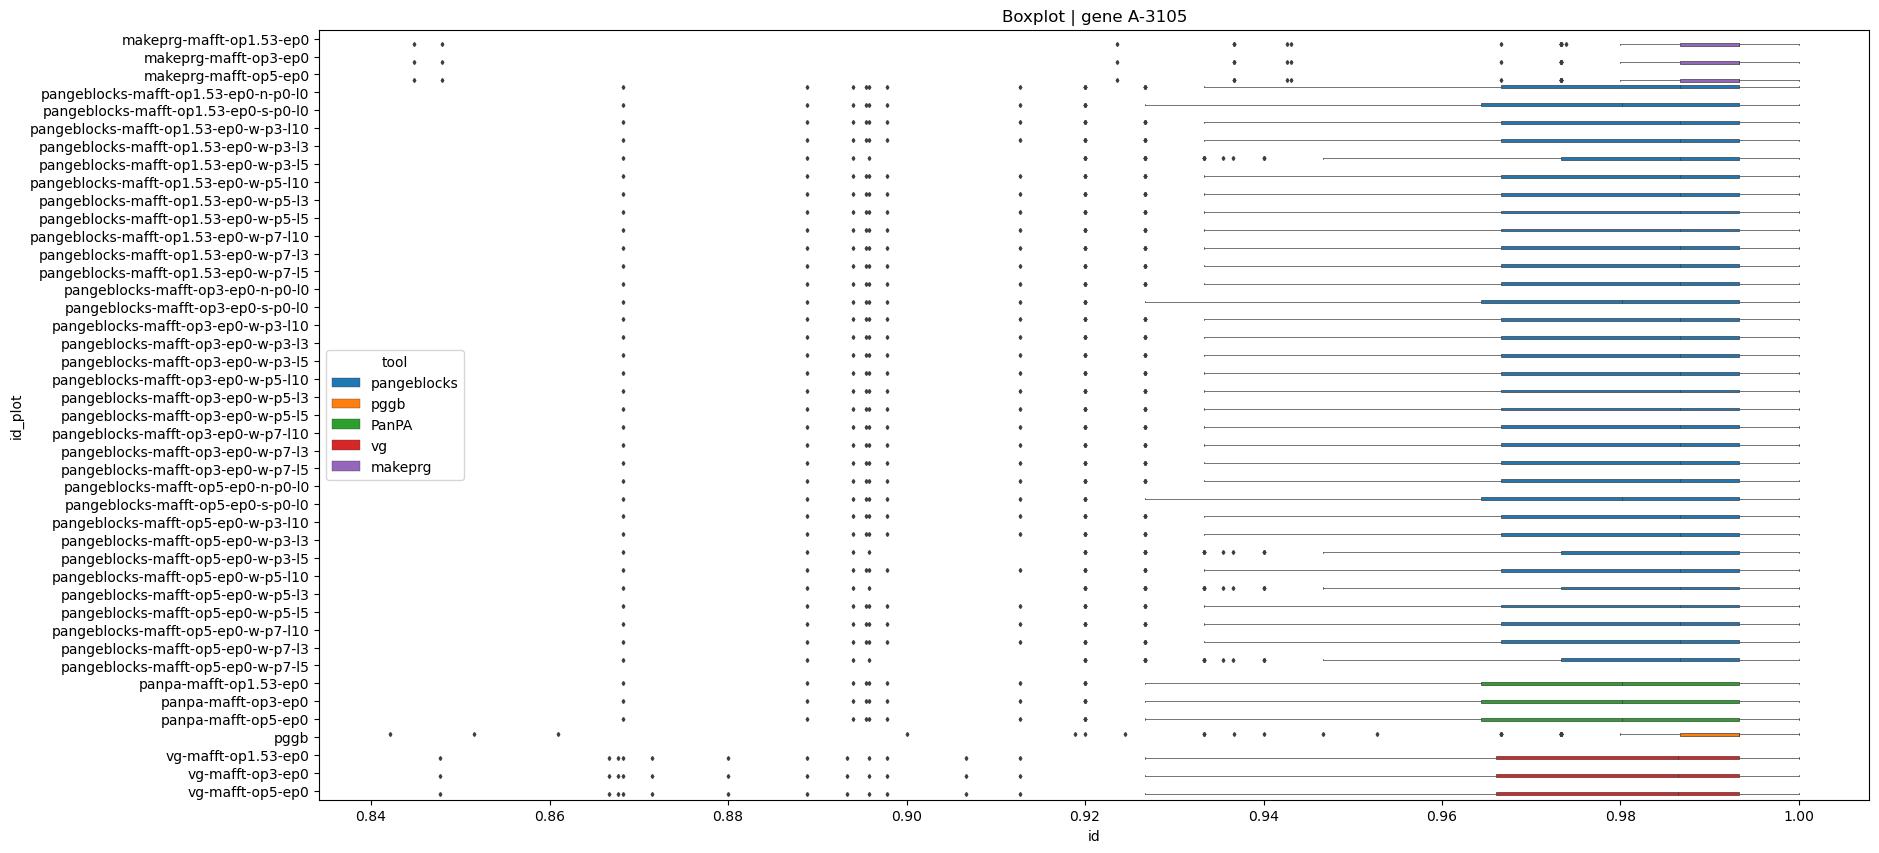

In [12]:
seqid= next(iter_seqsid)
seqid="A-3105"
threshold_mapping_quality = 0.9

data_boxplot = data_gafs.query(f"seqsid=='{seqid}' and mapping_quality>{threshold_mapping_quality}")
order_labels = sorted(list(data_boxplot["id_plot"].unique()))

plt.figure(figsize=(20,10))
ax_boxplot = sns.boxplot(
    data=data_boxplot, 
    x="id",
    y="id_plot",
    orient="h",
    hue="tool",
    order=order_labels,
    saturation=1,
    linewidth=0.5,
    fliersize=2.0,
    )
ax_boxplot.set_title(f"Boxplot | gene {seqid}")

Text(0.5, 1.0, 'Number of aligned reads | gene A-3105')

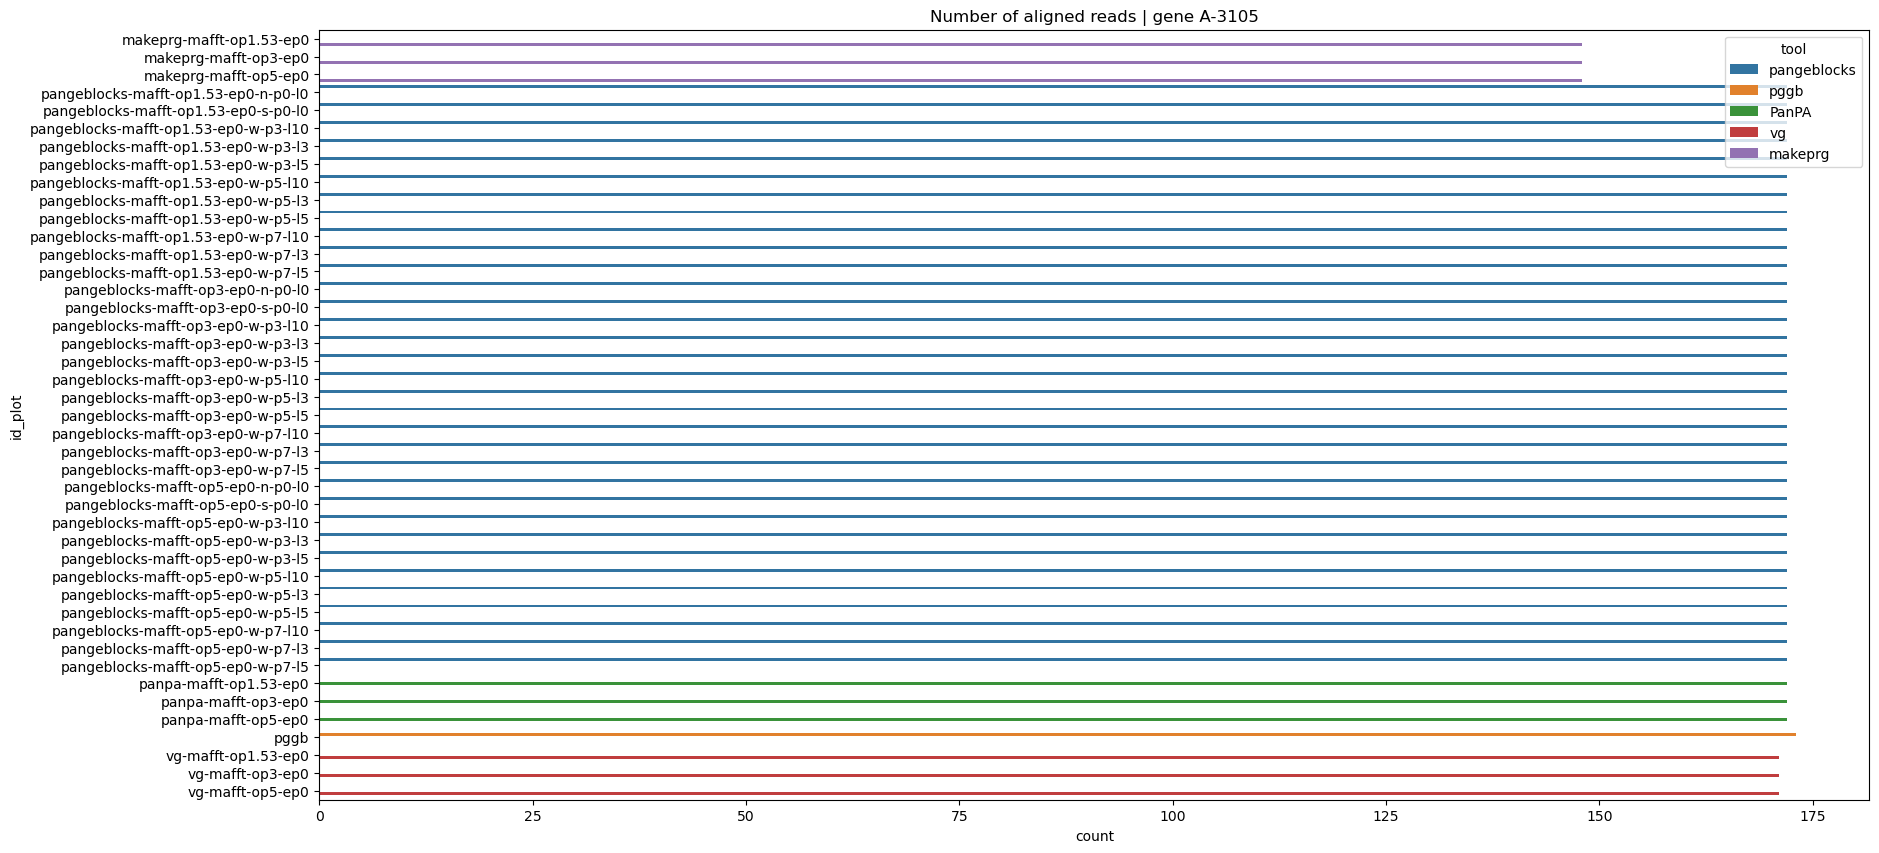

In [13]:
plt.figure(figsize=(20,10))
ax_count=sns.countplot(
    data=data_boxplot, 
    y="id_plot", 
    hue="tool", 
    orient="h", 
    order=order_labels
    )
ax_count.set_title(f"Number of aligned reads | gene {seqid}")


Text(0.5, 1.0, 'Number of existing paths the reads are aligned against | gene A-3105 ')

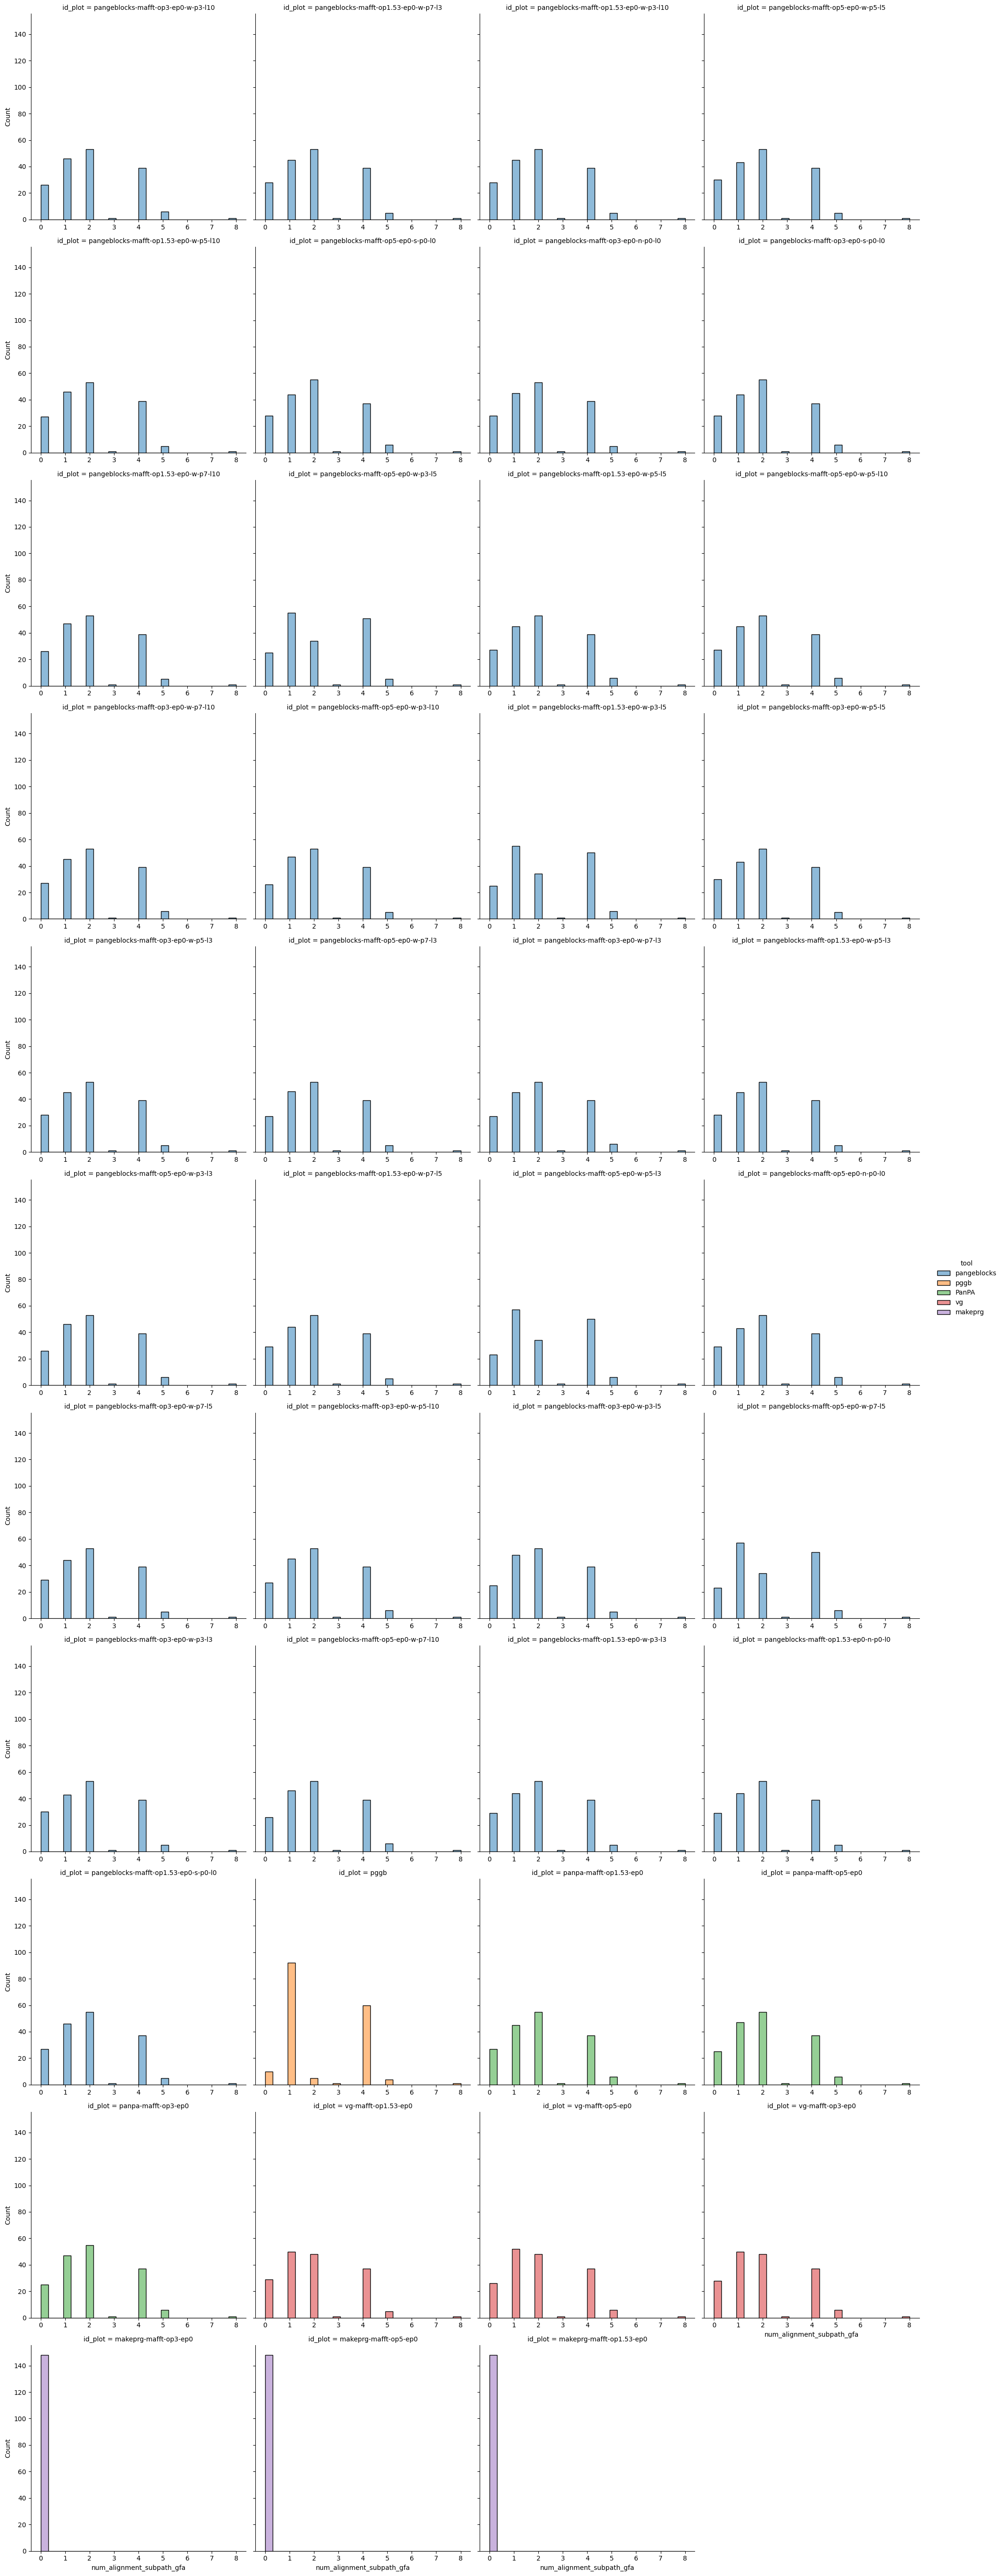

In [14]:
ax_align_subpaths = sns.displot(
    data=data_boxplot,
    col="id_plot",
    x="num_alignment_subpath_gfa",
    hue="tool",
    col_wrap=4,
    facet_kws=dict(sharex=False)
)

ax_count.set_title(f"Number of existing paths the reads are aligned against | gene {seqid} ")



## "Best" graph for each gene 
where "best" correspond (in this case) to the graph with maximum number of reads aligned

In [25]:
seqsid = sorted(data_gafs["seqsid"].unique())
counts_by_seqid = data_gafs.query(f"mapping_quality>{threshold_mapping_quality}").groupby(["seqsid","tool","id_plot"]).count()["query_seq_name"].copy()

In [26]:
best_graphs = []
for seqid in seqsid:

    idx_seqid = counts_by_seqid.index.isin([seqid], level=0)
    multi_idx = counts_by_seqid[idx_seqid].idxmax()
    maxvalue  = counts_by_seqid[idx_seqid][multi_idx]

    best_graphs.append(
        (multi_idx, maxvalue)
    )


In [27]:
best_graphs = pd.Series(
            [v[1] for v in best_graphs], 
            index=pd.MultiIndex.from_tuples([v[0] for v in best_graphs])
            ) 
            

In [28]:
best_graphs

A-3105          pggb         pggb                                   173
B-3106          makeprg      makeprg-mafft-op1.53-ep0               163
C-3107          makeprg      makeprg-mafft-op1.53-ep0               164
DMA-3108        PanPA        panpa-mafft-op1.53-ep0                 224
DMB-3109        vg           vg-mafft-op1.53-ep0                    319
DOA-3111        PanPA        panpa-mafft-op1.53-ep0                 271
DOB-3112        pggb         pggb                                   232
DPA1-3113       vg           vg-mafft-op1.53-ep0                    809
DPB1-3115       vg           vg-mafft-op1.53-ep0                    677
DQA1-3117       pangeblocks  pangeblocks-mafft-op3-ep0-n-p0-l0      798
DQB1-3119       makeprg      makeprg-mafft-op1.53-ep0               305
DRA-3122        vg           vg-mafft-op1.53-ep0                    258
DRB1-3123       pangeblocks  pangeblocks-mafft-op3-ep0-w-p3-l10     390
DRB3-3125       vg           vg-mafft-op1.53-ep0                

In [29]:
pd.DataFrame(best_graphs.index.tolist(), columns=["seqid","tool","id_plot"]). \
    groupby(["tool"]).size()

tool
PanPA           2
makeprg         9
pangeblocks     2
pggb            3
vg             12
dtype: int64

___
## Venn Diagrams
Check reads that are aligned for each tool (and shared)

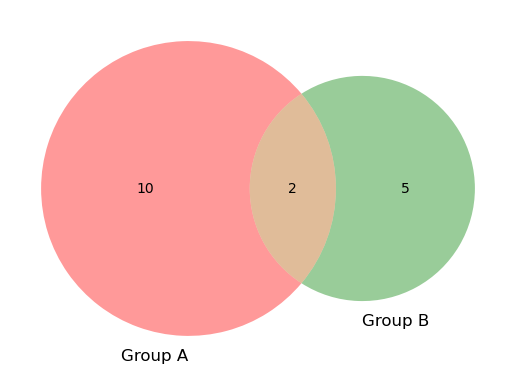

In [32]:
# choose one seqid
seqid = "A-3105"


# library
import matplotlib.pyplot as plt
from matplotlib_venn import venn2, venn3

# Use the venn2 function
venn2(subsets = (10, 5, 2), set_labels = ('Group A', 'Group B'))
plt.show()

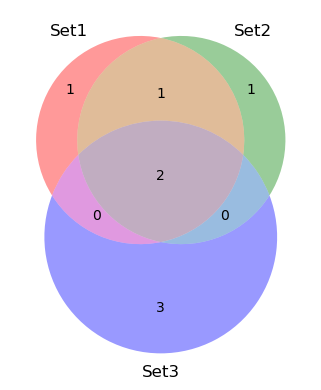

In [33]:
set1 = set(['A', 'B', 'C', 'D'])
set2 = set(['B', 'C', 'D', 'E'])
set3 = set(['C', 'D',' E', 'F', 'G'])

venn3([set1, set2, set3], ('Set1', 'Set2', 'Set3'))
plt.show()

In [ ]:
### Considerar upsetplot 
https://jokergoo.github.io/ComplexHeatmap-reference/book/upset-plot.html


___
## Checking manually reads for gene C-3107
- Why pggb and vg align less reads than pangeblocks?
- get reads aligned by pangeblocks and not by pggb 
- get reads aligned by pangeblocks and not by vg


In [19]:
""" seqid="C-3107"
TOOL="pggb"
with(open(BASEPATH_ALIGN.joinpath(TOOL) / "gfaid_to_paths.json" )) as fp: 
    gfaid_to_paths=json.load(fp)

path_gaf="/data/pangeblocks-experiments/alignment-simulated-reads-HLA-zoo/pggb/C-3107/C-3107.gfaid16.alignment.gaf"
path_gfa="../"+gfaid_to_paths["16"]

gaf_pggb = load_gaf(path_gaf=path_gaf, path_gfa=path_gfa)
gaf_pggb.shape """

' seqid="C-3107"\nTOOL="pggb"\nwith(open(BASEPATH_ALIGN.joinpath(TOOL) / "gfaid_to_paths.json" )) as fp: \n    gfaid_to_paths=json.load(fp)\n\npath_gaf="/data/pangeblocks-experiments/alignment-simulated-reads-HLA-zoo/pggb/C-3107/C-3107.gfaid16.alignment.gaf"\npath_gfa="../"+gfaid_to_paths["16"]\n\ngaf_pggb = load_gaf(path_gaf=path_gaf, path_gfa=path_gfa)\ngaf_pggb.shape '

In [20]:
# sns.histplot(data=gaf_pggb,x="id")

In [21]:
""" TOOL="vg"
with(open(BASEPATH_ALIGN.joinpath(TOOL) / "gfaid_to_paths.json" )) as fp: 
    gfaid_to_paths=json.load(fp)

path_gaf="/data/pangeblocks-experiments/alignment-simulated-reads-HLA-zoo/vg/C-3107/C-3107.gfaid24.alignment.gaf"
path_gfa="../" + gfaid_to_paths["24"]

gaf_vg=load_gaf(path_gaf=path_gaf, path_gfa=path_gfa)
gaf_vg.shape """

' TOOL="vg"\nwith(open(BASEPATH_ALIGN.joinpath(TOOL) / "gfaid_to_paths.json" )) as fp: \n    gfaid_to_paths=json.load(fp)\n\npath_gaf="/data/pangeblocks-experiments/alignment-simulated-reads-HLA-zoo/vg/C-3107/C-3107.gfaid24.alignment.gaf"\npath_gfa="../" + gfaid_to_paths["24"]\n\ngaf_vg=load_gaf(path_gaf=path_gaf, path_gfa=path_gfa)\ngaf_vg.shape '

In [22]:
""" TOOL="pangeblocks"
with(open(BASEPATH_ALIGN.joinpath(TOOL) / "gfaid_to_paths.json" )) as fp: 
    gfaid_to_paths=json.load(fp)

path_gaf="/data/pangeblocks-experiments/alignment-simulated-reads-HLA-zoo/pangeblocks/C-3107/C-3107.gfaid537.alignment.gaf"
path_gfa="../" + gfaid_to_paths["537"]

gaf_pangeblocks=load_gaf(path_gaf=path_gaf, path_gfa=path_gfa)
gaf_pangeblocks.shape """

' TOOL="pangeblocks"\nwith(open(BASEPATH_ALIGN.joinpath(TOOL) / "gfaid_to_paths.json" )) as fp: \n    gfaid_to_paths=json.load(fp)\n\npath_gaf="/data/pangeblocks-experiments/alignment-simulated-reads-HLA-zoo/pangeblocks/C-3107/C-3107.gfaid537.alignment.gaf"\npath_gfa="../" + gfaid_to_paths["537"]\n\ngaf_pangeblocks=load_gaf(path_gaf=path_gaf, path_gfa=path_gfa)\ngaf_pangeblocks.shape '

In [23]:
# 